In [70]:
import numpy as np
import pyproj
import math
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize
EARTH_RADIUS = 6371e3
DUE_EAST = 90
FOLLOW_DISTANCE = 3.0
CAR = 1
BROADCAST_INTERVAL = 0.1
CAR_LENGTH = 0.779
KPV = 0.2
KDV = 0.3
KPH = 0.3
KDH = 0.3
geodesic = pyproj.Geod(ellps='WGS84')

# Center of the running track; serves as reference point
center_latitude = (28.607980 + 28.607292) / 2
center_longitude = (-81.195662 + -81.194750) / 2
center_orientation = DUE_EAST

# def coords_to_local(current_lat, current_lon, current_heading, target_lat, target_lon):
#     # Convert lat, lon to radians
#     target_lat_rad, target_lon_rad = math.radians(target_lat), math.radians(target_lon)
#     current_lat_rad, current_lon_rad = math.radians(current_lat), math.radians(current_lon)

#     x = EARTH_RADIUS * (target_lon_rad - current_lon_rad) * math.cos((current_lat_rad + target_lat_rad) / 2)
#     y = EARTH_RADIUS * (target_lat_rad - current_lat_rad)

#     angle = math.radians(current_heading - DUE_EAST)
#     qx = math.cos(angle) * x - math.sin(angle) * y
#     qy = math.sin(angle) * x + math.cos(angle) * y
#     return qx, qy

def coords_to_local(target_lat, target_lon):
    # Convert lat, lon to radians
    target_lat_rad, target_lon_rad = math.radians(target_lat), math.radians(target_lon)
    current_lat_rad, current_lon_rad = math.radians(center_latitude), math.radians(center_longitude)

    x = EARTH_RADIUS * (target_lon_rad - current_lon_rad) * math.cos((current_lat_rad + target_lat_rad) / 2)
    y = EARTH_RADIUS * (target_lat_rad - current_lat_rad)

    angle = math.radians(center_orientation - DUE_EAST)
    qx = math.cos(angle) * x - math.sin(angle) * y
    qy = math.sin(angle) * x + math.cos(angle) * y
    return qx, qy

def get_goal_motion(ego_car, target_cars):
    targets = []
    for i in range(CAR - 1, -1, -1):
        (lat1, lon1, head1, time1), (lat2, lon2, head2, time2) = target_cars[i]

        x1, y1 = coords_to_local(lat1, lon1)
        x2, y2 = coords_to_local(lat2, lon2)

        velocity = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)/(time2 - time1)
        heading = head2#math.degrees(np.arctan2(y2 - y1, x2 - x1)) #this is because, when we make the test points the car turns and then proceeds from lat1, lon1 to lat2, lon2
        targets.append((x2, y2, heading, velocity, CAR - 1 - i))

    assert len(targets) == 1, f"length of targets is: {len(targets)}, expected 1. targets is {targets}"

    def minimization_objective(params):
        v, head = params
        head = np.radians(head)
        # x, y = self.telem.pose.pose.position.x, self.telem.pose.pose.position.y
        x, y = coords_to_local(ego_car[1][0], ego_car[1][1])

        total_cost = 0
        for target in targets:
            x_target, y_target, head_target, v_target, position = target
            head_target = np.radians(head_target)
            goal_follow_distance = FOLLOW_DISTANCE*position + CAR_LENGTH*(position - 1)
            total_cost += np.abs(goal_follow_distance - np.sqrt((x_target + v_target*np.cos(head_target)*BROADCAST_INTERVAL - x - v*np.cos(head)*BROADCAST_INTERVAL)**2 + (y_target + v_target*np.sin(head_target)*BROADCAST_INTERVAL - y - v*np.sin(head)*BROADCAST_INTERVAL)**2))

        return total_cost
    
    res = minimize(minimization_objective, [1.0, 0.0], method='Nelder-Mead')

    return res, targets

def velocity_controller(v, v_ego):
    accel = KPV*(v - v_ego) + KDV*(v - v_ego)/BROADCAST_INTERVAL
    return accel

def heading_controller(h, h_ego):
    steer = KPH*(h - h_ego) + KDH*(h - h_ego)/BROADCAST_INTERVAL
    return steer

In [71]:
straight_1 = [(28.607980, -81.195662), (28.607292, -81.195660)]
turn_1 = [(28.607292, -81.195660), (28.607294, -81.194750)]
straight_2 = [(28.607294, -81.194750), (28.607964, -81.194752)]
turn_2 = [(28.607964, -81.194752), (28.607980, -81.195662)]

target_speed = 2.0
broadcast_int = 0.1

seg_dist = target_speed*broadcast_int

bearing_1, _, straight_1_dist = geodesic.inv(straight_1[0][1], straight_1[0][0], straight_1[1][1], straight_1[1][0])
print(f"bearing for straight 1: {bearing_1}")
straight_1_seg_count = int(straight_1_dist/seg_dist)
straight_1_segs = [straight_1[0]]
straight_1_vectors = []
for frame in range(straight_1_seg_count):
    lat_prev, lon_prev = straight_1_segs[-1]
    lon_next, lat_next, _ = geodesic.fwd(lon_prev, lat_prev, bearing_1, seg_dist)
    straight_1_segs.append((lat_next, lon_next))
    straight_1_vectors.append((lat_prev, lon_prev, bearing_1, target_speed))

bearing_2, _, straight_2_dist = geodesic.inv(straight_2[0][1], straight_2[0][0], straight_2[1][1], straight_2[1][0])
print(f"bearing for straight 2: {bearing_2}")
straight_2_seg_count = int(straight_2_dist/seg_dist)
straight_2_segs = [straight_2[0]]
straight_2_vectors = []
for frame in range(straight_2_seg_count):
    lat_prev, lon_prev = straight_2_segs[-1]
    lon_next, lat_next, _ = geodesic.fwd(lon_prev, lat_prev, bearing_2, seg_dist)
    straight_2_segs.append((lat_next, lon_next))
    straight_2_vectors.append((lat_prev, lon_prev, bearing_2, target_speed))

_, _, turn_1_dist = geodesic.inv(turn_1[0][1], turn_1[0][0], turn_1[1][1], turn_1[1][0])
turn_1_arclen = math.pi*(turn_1_dist/2)
turn_1_seg_count = int(turn_1_arclen/seg_dist)
bearing_diff_roc = (bearing_2 - bearing_1)/turn_1_seg_count
print(f"starting bearing for turn 1: {bearing_1}, ending bearing for turn 1: {bearing_2}, bearing diff: {bearing_diff_roc}")
turn_1_segs = [(turn_1[0][0], turn_1[0][1], bearing_1)]
turn_1_vectors = []
for frame in range(turn_1_seg_count):
    lat_prev, lon_prev, bearing_prev = turn_1_segs[-1]
    bearing_next = bearing_prev + bearing_diff_roc
    lon_next, lat_next, _ = geodesic.fwd(lon_prev, lat_prev, bearing_next, seg_dist)
    turn_1_segs.append((lat_next, lon_next, bearing_next))
    turn_1_vectors.append((lat_prev, lon_prev, bearing_next, target_speed))

_, _, turn_2_dist = geodesic.inv(turn_2[0][1], turn_2[0][0], turn_2[1][1], turn_2[1][0])
turn_2_arclen = math.pi*(turn_2_dist/2)
turn_2_seg_count = int(turn_2_arclen/seg_dist)
bearing_diff_roc = (bearing_2 - bearing_1)/turn_2_seg_count
print(f"starting bearing for turn 2: {bearing_2}, ending bearing for turn 2: {bearing_1}, bearing diff: {bearing_diff_roc}")
turn_2_segs = [(turn_2[0][0], turn_2[0][1], bearing_2)]
turn_2_vectors = []
for frame in range(turn_2_seg_count):
    lat_prev, lon_prev, bearing_prev = turn_2_segs[-1]
    bearing_next = bearing_prev + bearing_diff_roc
    lon_next, lat_next, _ = geodesic.fwd(lon_prev, lat_prev, bearing_next, seg_dist)
    turn_2_segs.append((lat_next, lon_next, bearing_next))
    turn_2_vectors.append((lat_prev, lon_prev, bearing_next, target_speed))

full_track = []
target_vectors = straight_1_vectors + turn_1_vectors + straight_2_vectors + turn_2_vectors
time = 0
for point in straight_1_segs:
    full_track.append((point[0], point[1], bearing_1, time))
    time += broadcast_int

for point in turn_1_segs:
    full_track.append((point[0], point[1], point[2], time))
    time += broadcast_int

for point in straight_2_segs:
    full_track.append((point[0], point[1], bearing_2, time))
    time += broadcast_int

for point in turn_2_segs:
    full_track.append((point[0], point[1], point[2], time))
    time += broadcast_int

bearing for straight 1: 179.85301627489667
bearing for straight 2: -0.15093156324882892
starting bearing for turn 1: 179.85301627489667, ending bearing for turn 1: -0.15093156324882892, bearing diff: -0.25751637745085193
starting bearing for turn 2: -0.15093156324882892, ending bearing for turn 2: 179.85301627489667, bearing diff: -0.25751637745085193


In [72]:
ego = [(28.608156, -81.195606, 0), (28.608154723971715, -81.19560744596528, 0)]
ego_start_heading, _, _ = geodesic.inv(ego[0][1], ego[0][0], ego[1][1], ego[1][0])
ego_vectors = [(ego[0][0], ego[0][1], 180, 0)] # lat, lon, heading, velocity
# ego_vectors = []
ego_targets = [(0,0)]
# ego_controls = [(0,0)]

for frame in range(1, len(full_track)):
    ego_car = [ego[-2], ego[-1]]
    target_cars = [[full_track[frame-1], full_track[frame]]]
    res, targets = get_goal_motion(ego_car, target_cars)
    v, head = res.x
    ego_targets.append((v, head))

    head_ego, _, current_dist = geodesic.inv(ego_car[0][1], ego_car[0][0], ego_car[1][1], ego_car[1][0])
    v_ego = current_dist/broadcast_int

    # ego_vectors.append((ego_car[0][0], ego_car[0][1], head_ego, v_ego))

    vel_accel = velocity_controller(v, v_ego)
    steer_accel = heading_controller(head, head_ego)
    # ego_controls.append((vel_accel, steer_accel))

    new_speed = v_ego + vel_accel*BROADCAST_INTERVAL
    new_heading = head_ego + steer_accel*BROADCAST_INTERVAL

    lon_next, lat_next, _ = geodesic.fwd(ego_car[1][1], ego_car[1][0], new_heading, new_speed*BROADCAST_INTERVAL)
    ego.append((lat_next, lon_next, new_speed))
    ego_vectors.append((ego_car[1][0], ego_car[1][1], new_heading, new_speed))

In [49]:
print(len(target_vectors), len(ego_vectors))

2150 2154


init_func
init_func
init_func


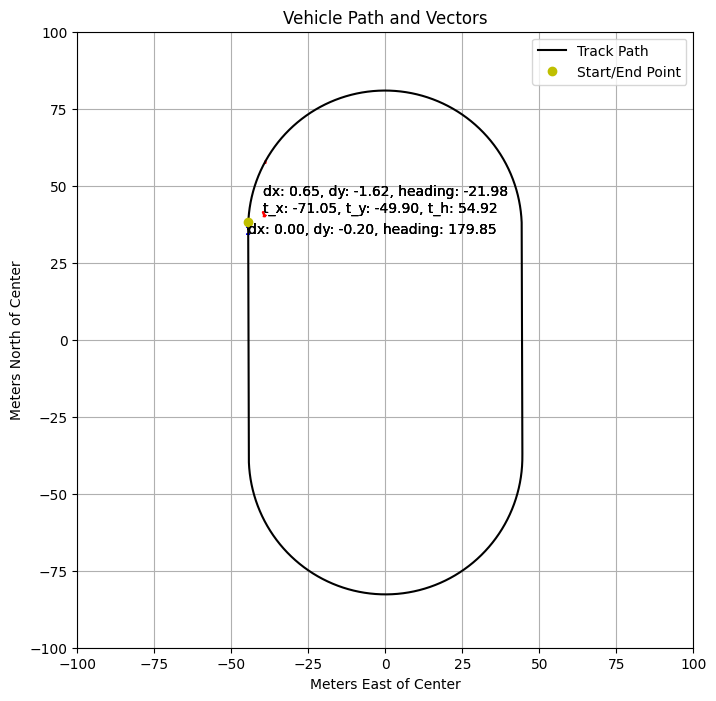

In [73]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib.text import Annotation
from IPython.display import HTML
import math

def heading_velocity_to_components(heading, velocity):
    # Convert heading (degrees) to radians
    heading_rad = math.radians(heading)
    # Calculate the x and y components of the velocity
    vx = velocity * math.sin(heading_rad)
    vy = velocity * math.cos(heading_rad)
    return vx, vy

def vector_to_arrow(vector):
    x, y = coords_to_local(vector[0], vector[1])
    vx, vy = heading_velocity_to_components(vector[2], vector[3])
    return (x, y, vx, vy)

# Convert all track points for plotting running track
xy_points = [coords_to_local(lat, lon) for lat, lon, heading, time in full_track]
xs = [point[0] for point in xy_points]
ys = [point[1] for point in xy_points]

# set up the plot and plot the runing track
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(autoscale_on=False, xlim=(-100, 100), ylim=(-100, 100))
ax.plot(xs, ys, 'k-', label='Track Path')  # green dots connected by lines
ax.plot(xs[0], ys[0], 'yo', label='Start/End Point')
ax.set_aspect('equal')

ex, ey, edx, edy = vector_to_arrow(ego_vectors[0])
v, h = ego_targets[0]
# vacc, hacc = ego_controls[0]
tx, ty, tdx, tdy = vector_to_arrow(target_vectors[0])
ego_arrow = patches.Arrow(ex, ey, edx, edy, width=2, fc='red', ec='red')
target_arrow = patches.Arrow(tx, ty, tdx, tdy, width=2, fc='blue', ec='blue')
ego_text = Annotation(f"dx: {edx:.2f}, dy: {edy:.2f}\nv: {v}, h: {h}", xy=(ex, ey), xytext=(ex, ey))
target_text = Annotation(f"dx: {tdx:.2f}, dy: {tdy:.2f}", xy=(tx, ty), xytext=(tx, ty))

def init_func() -> list[patches.Arrow]:
    print('init_func')
    ax.add_patch(ego_arrow)
    ax.add_patch(target_arrow)
    ax.add_artist(ego_text)
    ax.add_artist(target_text)
    return ego_arrow, target_arrow, ego_text, target_text

def func(frame, *fargs) -> list[patches.Arrow]:
    global ego_arrow, target_arrow, ego_text, target_text

    ax.patches[ax.patches.index(ego_arrow)].remove()
    ax.patches[ax.patches.index(target_arrow)].remove()

    _, _, e_heading, _ = ego_vectors[frame]
    _, _, t_heading, _ = target_vectors[frame]
    v, h = ego_targets[frame]
    vx, vy = heading_velocity_to_components(h, v)
    # vacc, hacc = ego_controls[frame]
    # accx, accy = heading_velocity_to_components(hacc, vacc)
    ex, ey, edx, edy = vector_to_arrow(ego_vectors[frame])
    tx, ty, tdx, tdy = vector_to_arrow(target_vectors[frame])
    ego_arrow = patches.Arrow(ex, ey, edx*broadcast_int, edy*broadcast_int, width=2, fc='red', ec='red')
    target_arrow = patches.Arrow(tx, ty, tdx*broadcast_int, tdy*broadcast_int, width=2, fc='blue', ec='blue')
    ego_text.set_text(f"dx: {edx*broadcast_int:.2f}, dy: {edy*broadcast_int:.2f}, heading: {e_heading:.2f}\nt_x: {vx:.2f}, t_y: {vy:.2f}, t_h: {h:.2f}")#\naccx: {accx:.2f}, accy: {accy:.2f}")
    ego_text.set_position((ex, ey))
    target_text.set_text(f"dx: {tdx*broadcast_int:.2f}, dy: {tdy*broadcast_int:.2f}, heading: {t_heading:.2f}")
    target_text.set_position((tx, ty))
    ax.add_patch(ego_arrow)
    ax.add_patch(target_arrow)
    return ego_arrow, target_arrow, ego_text, target_text

ax.set_xlabel('Meters East of Center')
ax.set_ylabel('Meters North of Center')
ax.set_title('Vehicle Path and Vectors')
ax.legend()
ax.grid()

# Create animation
ani = FuncAnimation(fig, func, 20, init_func, blit=True, interval=200) # Adjust interval as needed
HTML(ani.to_jshtml())
# plt.show()